In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
#
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

import tools
import importlib
importlib.reload(tools)

<module 'tools' from '/home/keithyamkf/jupyter-notebook/slack-trading/tools.py'>

### Download data from AWS S3

In [2]:
s3_bucket = 'slack-trading'
local_path = '../data/us_hk'
tools.download_data_from_s3(s3_bucket, local_path)

### CPU Count

In [3]:
cpu_count()

16

### Begin

In [4]:
# dataset = pd.read_csv('../data/all_stock_close.csv')
dataset = pd.read_csv('../data/us_hk/us_hk_clean_10yr_stock_close.csv')
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', drop=True, inplace=True)
dataset.head(3)

,0001.HK,0002.HK,0003.HK,0004.HK,0005.HK,0006.HK,0007.HK,0008.HK,0010.HK,0011.HK,...,TSM,TWM,UMC,V,VECO,VFC,VRNT,WDC,WFC,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2010-12-23,57.525002,42.099766,5.863498,7.826928,49.750565,27.087934,0.72,1.867227,40.748775,83.338463,...,8.748799,194.043121,1.971657,15.958306,43.240002,16.206656,31.520000,26.561853,23.103243,41.858631
2010-12-28,56.334431,41.966953,5.800245,7.799201,49.283875,26.950289,0.71,1.890068,40.080761,82.240196,...,8.755950,193.886765,1.952327,16.422682,43.590000,16.199192,31.690001,26.569702,23.259796,41.967972
2010-12-29,57.905922,42.365368,5.895123,8.097270,49.750565,27.142986,0.72,1.935749,40.827366,83.661453,...,8.806028,193.261322,1.965214,16.392496,43.110001,16.249552,31.540001,26.420523,23.125603,42.233482


In [5]:
train_start = '2011-01-01'
train_end = '2011-12-31'
dataset = dataset[train_start:train_end]

In [6]:
prevday_returns = np.log(dataset.shift(1)/dataset.shift(2))
today_returns = np.log(dataset/dataset.shift(1))
#
stocks_prev = prevday_returns.columns.to_list()
stocks_today_draft = today_returns.columns.to_list()

In [7]:
stocks_today = [s for s in stocks_today_draft if '.HK' in s]

In [8]:
new_col = ['{}.prev'.format(c) for c in stocks_prev]
prevday_returns.columns = new_col
#
comb_df = pd.concat([prevday_returns, today_returns[stocks_today]], axis=1)

In [9]:
comb_df.shape

(245, 1517)

### Fina the NaN in comb_df

In [10]:
comb_df.dropna(axis=0, how='any', inplace=True)

In [11]:
comb_df.tail(3)

,0001.HK.prev,0002.HK.prev,0003.HK.prev,0004.HK.prev,0005.HK.prev,0006.HK.prev,0007.HK.prev,0008.HK.prev,0010.HK.prev,0011.HK.prev,...,3900.HK,3918.HK,3933.HK,3968.HK,3988.HK,3989.HK,3993.HK,3998.HK,3999.HK,6823.HK
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-28,0.012451,0.002274,0.007808,0.011281,0.014316,0.003512,-0.029853,0.054347,0.042260,0.007547,...,-0.048374,0.005141,-0.002238,-0.017483,-0.020762,-0.057175,0.000000,-0.013129,-0.007435,0.000000
2011-12-29,0.004829,-0.007599,-0.001112,-0.025573,-0.010084,0.006987,-0.015268,-0.003839,-0.005764,-0.004845,...,-0.014685,0.005115,-0.009009,-0.008854,0.000000,-0.060644,-0.020495,-0.013304,-0.030305,0.000000
2011-12-30,-0.009142,-0.000763,-0.006697,-0.004321,-0.013606,-0.008741,0.000000,0.041437,0.009206,-0.003243,...,-0.002963,0.000000,0.011247,-0.002545,0.000000,0.459543,-0.017911,-0.018019,0.015268,0.013247


In [12]:
comb_df.head(3)

,0001.HK.prev,0002.HK.prev,0003.HK.prev,0004.HK.prev,0005.HK.prev,0006.HK.prev,0007.HK.prev,0008.HK.prev,0010.HK.prev,0011.HK.prev,...,3900.HK,3918.HK,3933.HK,3968.HK,3988.HK,3989.HK,3993.HK,3998.HK,3999.HK,6823.HK
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-05,0.012648,-0.005488,0.002165,0.001615,0.003118,0.001009,-0.027029,0.008607,0.000955,-0.001539,...,0.006369,0.000000,0.002567,0.002462,-0.007203,-0.028982,0.010612,0.040191,0.000000,-0.008772
2011-01-06,0.010938,0.004706,-0.001083,-0.011347,0.023994,0.001009,-0.013793,-0.014388,0.004764,0.017564,...,0.015748,0.056834,-0.033907,0.000000,0.002407,0.000000,-0.017302,-0.021440,-0.006473,0.008268
2011-01-07,0.021523,0.004684,-0.014168,0.004068,0.005456,-0.002018,0.013793,0.014388,0.006632,-0.000757,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.063791


In [13]:
prevday_returns = comb_df[new_col]
today_returns = comb_df[stocks_today]

In [14]:
print('{} {}'.format(len(new_col), len(stocks_today)))

804 713


In [15]:
def get_linear_regression(pair, prevday_returns, today_returns):
    catstocks = pair['prev']
    column = pair['today']
    X = prevday_returns[catstocks].copy()
    X = sm.add_constant(X)
    y = today_returns[column]
    model = sm.OLS(y, X).fit()
    data = {
        'Prev' : catstocks,
        'Today' : column,
        'Params' : model.params.iloc[1],
        'TValues' : abs(model.tvalues.iloc[1]),
        'RSquared' : model.rsquared
    }
    # print(data)
    return data

### Count how many null cells

In [16]:
comb_df.isna().sum().sum()

0

In [17]:
comb_df.describe()

,0001.HK.prev,0002.HK.prev,0003.HK.prev,0004.HK.prev,0005.HK.prev,0006.HK.prev,0007.HK.prev,0008.HK.prev,0010.HK.prev,0011.HK.prev,...,3900.HK,3918.HK,3933.HK,3968.HK,3988.HK,3989.HK,3993.HK,3998.HK,3999.HK,6823.HK
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,...,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,-0.001109,0.000251,0.000420,-0.002011,-0.001184,0.000732,-0.003441,-0.000648,-0.000675,-0.001219,...,-0.004028,0.000609,-0.005046,-0.000998,-0.001391,-0.002514,-0.002627,-0.001307,-0.000562,0.009526
std,0.019639,0.009693,0.011412,0.024276,0.018760,0.012182,0.035699,0.020005,0.021314,0.013875,...,0.032684,0.028930,0.031723,0.029807,0.020966,0.056175,0.031748,0.033754,0.027135,0.163456
min,-0.063870,-0.040283,-0.043257,-0.084447,-0.095753,-0.031003,-0.170625,-0.061748,-0.068098,-0.055713,...,-0.177111,-0.182321,-0.174802,-0.126159,-0.074348,-0.257835,-0.136132,-0.086409,-0.107054,-0.071509
25%,-0.011702,-0.004768,-0.005405,-0.014910,-0.010437,-0.007203,-0.017546,-0.011729,-0.012546,-0.006853,...,-0.017266,-0.011268,-0.022975,-0.015814,-0.012637,-0.029195,-0.014982,-0.019705,-0.013072,-0.009435
50%,-0.000857,0.000000,0.001120,-0.001223,0.000000,0.000814,0.000000,-0.002912,0.000000,-0.000824,...,-0.002861,0.000000,-0.003058,0.000000,0.000000,-0.010377,-0.001557,-0.006154,0.000000,-0.002174
75%,0.010118,0.005397,0.007175,0.010098,0.009158,0.008077,0.013255,0.010583,0.010608,0.006311,...,0.011561,0.012540,0.013244,0.012800,0.009154,0.015089,0.013050,0.017700,0.011561,0.008874
max,0.075051,0.028419,0.038829,0.090241,0.054205,0.039474,0.125163,0.054347,0.073815,0.050111,...,0.163854,0.095848,0.101067,0.132091,0.098699,0.459543,0.115975,0.130620,0.141412,2.528323


### Generate pair list

In [18]:
catstocks = new_col
pair_list = []
for column in today_returns.columns:
    for catstock in catstocks:
        if column not in catstock:
            data = {
                'prev' : [catstock],
                'today' : column
            }
            pair_list.append(data)
#

### Non parallel processing

In [ ]:
%%time
#
results = [get_linear_regression(pair, prevday_returns, today_returns) for pair in pair_list]
result_df = pd.DataFrame(results)
result_df

### Parrallel processing

In [19]:
%%time
cpu = cpu_count()
print('cpu count = {}'.format(cpu))
executor = Parallel(n_jobs=cpu, backend='multiprocessing')
tasks = (delayed(get_linear_regression)(pair, prevday_returns, today_returns) for pair in pair_list)
results = executor(tasks)
result_df = pd.DataFrame(results)
result_df

cpu count = 16


/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwar

/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: inva

CPU times: user 2min 24s, sys: 6.63 s, total: 2min 31s
Wall time: 24min 32s


,Prev,Today,Params,TValues,RSquared
0,[0002.HK.prev],0001.HK,-0.039703,0.304567,0.000385
1,[0003.HK.prev],0001.HK,-0.083944,0.758921,0.002384
2,[0004.HK.prev],0001.HK,0.022873,0.439567,0.000801
3,[0005.HK.prev],0001.HK,-0.021963,0.326115,0.000441
4,[0006.HK.prev],0001.HK,0.100881,0.974367,0.003924
...,...,...,...,...,...
572534,[VFC.prev],6823.HK,1.581889,3.293845,0.043079
572535,[VRNT.prev],6823.HK,1.264958,3.135673,0.039199
572536,[WDC.prev],6823.HK,0.831055,2.442572,0.024158
572537,[WFC.prev],6823.HK,0.659192,1.561067,0.010011


In [20]:
result_df.head(5)

,Prev,Today,Params,TValues,RSquared
0,[0002.HK.prev],0001.HK,-0.039703,0.304567,0.000385
1,[0003.HK.prev],0001.HK,-0.083944,0.758921,0.002384
2,[0004.HK.prev],0001.HK,0.022873,0.439567,0.000801
3,[0005.HK.prev],0001.HK,-0.021963,0.326115,0.000441
4,[0006.HK.prev],0001.HK,0.100881,0.974367,0.003924


In [21]:
result_df.to_csv('../data/us_hk/us_hk_10yr_regression_pair.csv')

### Read Regression Result

In [22]:
result_df = pd.read_csv('../data/us_hk/us_hk_10yr_regression_pair.csv', index_col=0)

In [23]:
sorted_df = result_df.sort_values(by='RSquared', ascending=False)
sorted_df.head(10)

,Prev,Today,Params,TValues,RSquared
348463,['MFC.prev'],0945.HK,0.690853,18.223915,0.579488
348493,['TWM.prev'],0945.HK,-0.389780,13.076561,0.415043
348479,['SKF.prev'],0945.HK,-0.398197,13.007148,0.412462
348475,['OMC.prev'],0945.HK,0.833398,12.538312,0.394791
348426,['CAT.prev'],0945.HK,0.641857,12.296938,0.385541
536395,['TWM.prev'],2888.HK,-0.304820,12.274507,0.384676
348432,['DE.prev'],0945.HK,0.714601,12.247470,0.383633
348457,['JPM.prev'],0945.HK,0.601032,12.234116,0.383117
3992,['SKF.prev'],0005.HK,-0.287341,12.173094,0.380756
3946,['DIS.prev'],0005.HK,0.583540,12.153733,0.380006


### Analyze the Top pair

MFC
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Total prev stock rise 124
Total prev stock rise and today rise 101


/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


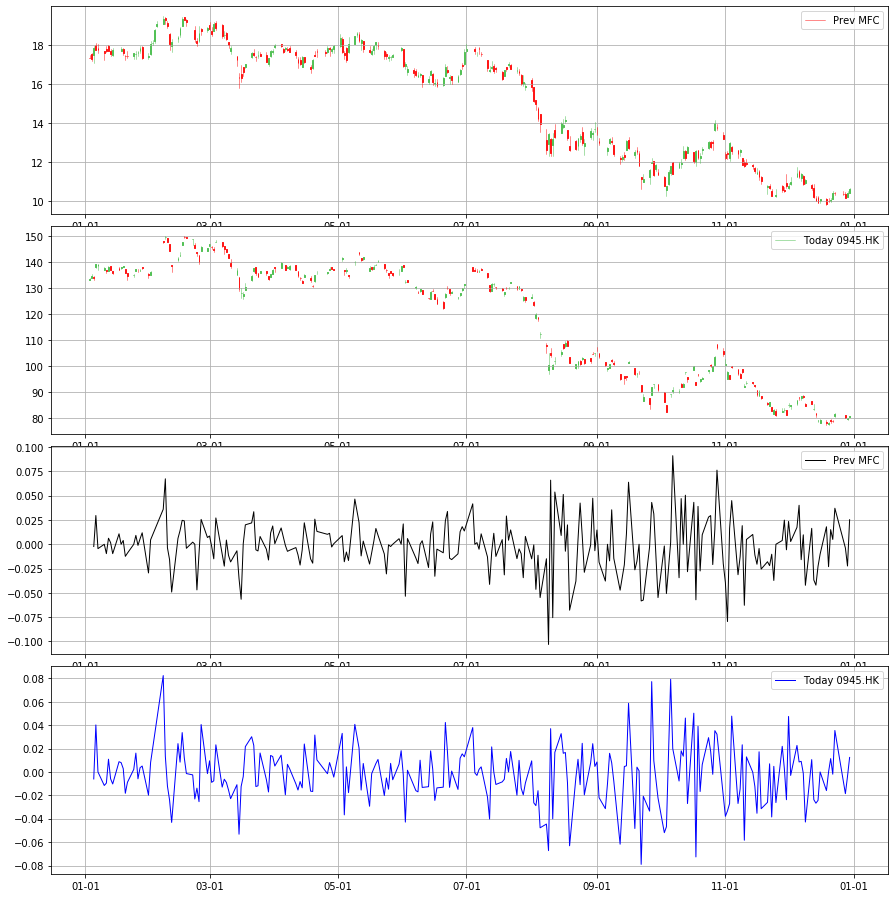

In [24]:
stock1 = 'MFC.prev'
stock2 = '0945.HK'
#
tools.plot_two_stocks(stock1, stock2, prevday_returns, today_returns, train_start, train_end)

### Upload to AWS S3

In [ ]:
s3_bucket = 'slack-trading'
local_path = '../data/us_hk'
tools.upload_data_to_s3(s3_bucket, local_path)

### Verify Linear regression

    catstock = pair['prev']
    column = pair['today']
    X = prevday_returns[[catstock]].copy()
    X = sm.add_constant(X)
    y = today_returns[[column]]
    model = sm.OLS(y, X).fit()
    data = {
        'Prev' : catstock,
        'Today' : column,
        'Params' : model.params.iloc[1],
        'TValues' : abs(model.tvalues.iloc[1]),
        'RSquared' : model.rsquared
    }

In [ ]:
prevday_returns[stock1]

In [ ]:
today_returns[stock2]

In [ ]:
X = prevday_returns[stock1].copy()
X = sm.add_constant(X)
y = today_returns[stock2]
model = sm.OLS(y, X).fit()
print('Params {:.4f} TValues {:.4f} RSquared {:.4f}'.format(model.params.iloc[1], model.tvalues.iloc[1], model.rsquared))

In [ ]:
sorted_df[sorted_df['Today']=='^HSI'].sort_values(by='RSquared', ascending=False)